<a href="https://colab.research.google.com/github/gabriellambrecht/SentenceClassification/blob/main/Classificador_Sentencas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rotinas iniciais de preparação

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 5.2 MB/s 
     |████████████████████████████████| 3.3 MB 38.6 MB/s 
     |████████████████████████████████| 895 kB 40.7 MB/s 
     |████████████████████████████████| 56 kB 4.3 MB/s 
     |████████████████████████████████| 596 kB 47.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/TCC/')
!cp /content/drive/MyDrive/TCC/dataset_feedback.csv /content

Mounted at /content/drive


# Define qual dispositivo usará no treinamento


In [ ]:
import torch

# Se disponível usa o ambiente CUDA, senão usa o CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Define qual o tamanho máximo de frases

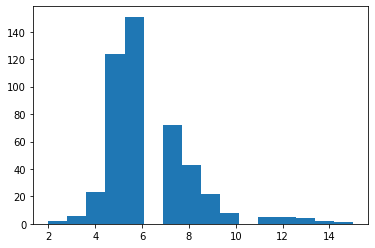

In [ ]:
import pandas as pd

dataset = pd.read_csv('dataset_feedback.csv', sep=',', header=None)
dataset.columns = ['text', 'label']

# Armazena em uma lista o tamanho de cada sentença
lista_tamanho = [len(i.split()) for i in dataset['text']]

# Monta e exibe o histograma do tamanho de cada sentença
pd.Series(lista_tamanho).hist(bins = 16, grid=False)

# Carrega dataset

In [ ]:
import numpy as np
import pandas as pd

dataset = pd.read_csv('dataset_feedback.csv', sep=',', header=None)
dataset.columns = ['text', 'label']
dataset.label = dataset.label+2
dataset.head()

,text,label
0,O funcionário possui pouquíssima perspicácia,0
1,O funcionário possui pouquíssima visão gerencial,0
2,O funcionário possui pouquíssima influência na...,0
3,O funcionário possui pouquíssima clareza,0
4,O funcionário possui pouquíssima qualidades,0


# Divide dataset em conjutos de treino, validação e teste


In [ ]:
from sklearn.model_selection import train_test_split

# Separa dataset original em dataset de treino e temporário
train_text, temp_text, train_labels, temp_labels = train_test_split(dataset['text'], dataset['label'], 
                                                                    random_state=2021, 
                                                                    test_size=0.3, 
                                                                    stratify=dataset['label'])
# Separa dataset temporário em dataset de validação e teste
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2021, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

# Import BERT Model and BERT Tokenizer

In [ ]:
import transformers
from transformers import AutoModel, AutoTokenizer

# Importa modelo Bertimbau pré-treinado em português
bert = AutoModel.from_pretrained('neuralmind/bert-large-portuguese-cased', num_labels=5)

# Importa tokenizer Bertimbau pré-treinamento em português
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-large-portuguese-cased')

Downloading:   0%|          | 0.00/648 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Some weights of the model checkpoint at neuralmind/bert-large-portuguese-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/155 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

# Tokenization

In [ ]:
# Define tamanho fixo das sentenças
max_seq_len = 17

def tokeniza_sentencas (sentencas):
  return tokenizer.batch_encode_plus(
          sentencas.tolist(),
          max_length = max_seq_len,
          padding='max_length',
          truncation=True,
          return_token_type_ids=False
  )

# Tokeniza as sentenças dos datasets de treinamento, validação e teste
tokens_train = tokeniza_sentencas(train_text)
tokens_val = tokeniza_sentencas(val_text)
tokens_test = tokeniza_sentencas(test_text)

# Convert Integer Sequences to Tensors

In [ ]:
import torch

# Transforma em tensores o conjunto de treinamento
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# Transforma em tensores o conjunto de validação
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# Transforma em tensores o conjunto de teste
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Create DataLoaders

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Define o batch size (tamanho de registro para cada iteração do treinamento)
batch_size = 32

# Monta um DataLoader do dataset de treinamento
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Monta um DataLoader do dataset de validação
val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Define Model Architecture

In [ ]:
import torch.nn as nn

class BERT_Arch(nn.Module):

    # Define o método de inicialização
    def __init__(self, bert):
      super(BERT_Arch, self).__init__()
      self.bert = bert 
      self.dropout = nn.Dropout(0.1)
      self.relu =  nn.ReLU()
      self.fc1 = nn.Linear(1024, 512)
      self.fc2 = nn.Linear(512,5)
      self.softmax = nn.LogSoftmax(dim=1)

    # Define o método de avanço
    def forward(self, sent_id, mask):
      cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)[1]
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)
      x = self.softmax(x)
      return x

# Calcula os pesos de classes

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#Calcula os pesos de cada classe
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)
print(class_wts)

[0.62884615 1.52093023 2.10967742 1.45333333 0.62884615]


In [ ]:
import torch.nn as nn

# Converte pesos das classes em tensor e armazena no dispositivo de execução
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# Configura classe de cálculo de perda usando os pesos 
cross_entropy  = nn.CrossEntropyLoss(weight=weights)

# Fine-Tune BERT

In [ ]:
from transformers import AdamW

# Congela parâmetros não utilizados
for param in bert.parameters():
    param.requires_grad = False

# Instância o modelo com a fine-tuning e armazena no dispositivo de execução
model = BERT_Arch(bert)
model = model.to(device)

# Define a função de otimização
optimizer = AdamW(model.parameters(), lr = 1e-3)

In [ ]:
def train():
  model.train()
  total_loss = 0
  for batch in train_dataloader:
    batch = [r.to(device) for r in batch]
    sent_id, mask, labels = batch
    model.zero_grad()        
    preds = model(sent_id, mask)
    loss = cross_entropy(preds, labels)
    total_loss = total_loss + loss.item()
    loss.backward()
    optimizer.step()
    preds=preds.detach().cpu().numpy()
  avg_loss = total_loss / len(train_dataloader)
  return avg_loss

In [ ]:
def evaluate():
  model.eval()
  total_loss = 0
  for batch in val_dataloader:
    batch = [t.to(device) for t in batch]
    sent_id, mask, labels = batch
    with torch.no_grad():
      preds = model(sent_id, mask)
      loss = cross_entropy(preds,labels)
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader) 
  return avg_loss

# Start Model Training

In [ ]:
best_valid_loss = float('inf')
epochs = 10

for epoch in range(epochs):
    print('\nEpoch {:} / {:}'.format(epoch + 1, epochs))

    train_loss = train()
    valid_loss = evaluate()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    print(f'Training Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


Epoch 1 / 10
Training Loss: 1.546
Validation Loss: 1.304

Epoch 2 / 10
Training Loss: 1.311
Validation Loss: 1.108

Epoch 3 / 10
Training Loss: 1.065
Validation Loss: 0.874

Epoch 4 / 10
Training Loss: 0.943
Validation Loss: 0.759

Epoch 5 / 10
Training Loss: 0.899
Validation Loss: 0.773

Epoch 6 / 10
Training Loss: 0.731
Validation Loss: 0.728

Epoch 7 / 10
Training Loss: 0.669
Validation Loss: 0.606

Epoch 8 / 10
Training Loss: 0.581
Validation Loss: 0.630

Epoch 9 / 10
Training Loss: 0.645
Validation Loss: 0.617

Epoch 10 / 10
Training Loss: 0.600
Validation Loss: 0.716


# Get Predictions for Test Data

In [ ]:
from sklearn.metrics import classification_report

# Carrega o estado do melhor modelo treinado
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

# Busca previsões para o dataset de teste
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()
  
# Imprime o relatório de classificação comparando as previsões e os valores reais
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.68      0.83      0.75        23
           1       0.78      0.78      0.78         9
           2       0.71      0.83      0.77         6
           3       1.00      0.80      0.89        10
           4       0.84      0.70      0.76        23

    accuracy                           0.77        71
   macro avg       0.80      0.79      0.79        71
weighted avg       0.79      0.77      0.78        71



In [ ]:
pd.crosstab(test_y, preds)

col_0,0,1,2,3,4
row_0,,,,,
0,19,1,0,0,3
1,2,7,0,0,0
2,0,1,5,0,0
3,0,0,2,8,0
4,7,0,0,0,16
